In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from tqdm import tqdm

# Path to the data directory
data_dir = "data/raw_taxi_logs"

# List all files in the directory
files = glob.glob(os.path.join(data_dir, "*.txt"))
print(f"Found {len(files)} files in {data_dir}")

# Function to read a single file
def read_taxi_file(file_path):
    try:
        # T-drive format typically has: taxi_id, datetime, longitude, latitude
        df = pd.read_csv(file_path, header=None, 
                        names=["taxi_id", "datetime", "longitude", "latitude"],
                        sep=",")
        
        # Convert datetime to proper format
        df["datetime"] = pd.to_datetime(df["datetime"])
        
        # Add file name as source
        df["source_file"] = os.path.basename(file_path)
        
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.DataFrame()

# Read a sample file to understand structure
if files:
    sample_df = read_taxi_file(files[0])
    print("\nSample data structure:")
    print(sample_df.head())
else:
    print("No files found in the directory")

# Analyze files (limiting to 10 for demonstration)
max_files_to_process = 10
files_to_process = files[:max_files_to_process]

# Read and combine data
all_data = []
for file in tqdm(files_to_process, desc="Reading files"):
    df = read_taxi_file(file)
    if not df.empty:
        all_data.append(df)



Found 10357 files in data/raw_taxi_logs

Sample data structure:
   taxi_id            datetime  longitude  latitude source_file
0        1 2008-02-02 15:36:08  116.51172  39.92123       1.txt
1        1 2008-02-02 15:46:08  116.51135  39.93883       1.txt
2        1 2008-02-02 15:46:08  116.51135  39.93883       1.txt
3        1 2008-02-02 15:56:08  116.51627  39.91034       1.txt
4        1 2008-02-02 16:06:08  116.47186  39.91248       1.txt


Reading files: 100%|██████████| 10/10 [00:00<00:00, 151.30it/s]



Combined data shape: (15759, 5)

Number of duplicate records: 674

Found 2827 potentially stationary periods (taxi stopped for >5 min)

Sample of stationary periods:
    taxi_id            datetime  time_diff  distance
18        1 2008-02-02 21:50:33      600.0  0.000032
19        1 2008-02-02 22:10:32     1199.0  0.000022
20        1 2008-02-02 22:20:32      600.0  0.000010
21        1 2008-02-02 22:30:32      600.0  0.000022
22        1 2008-02-02 22:40:33      601.0  0.000030


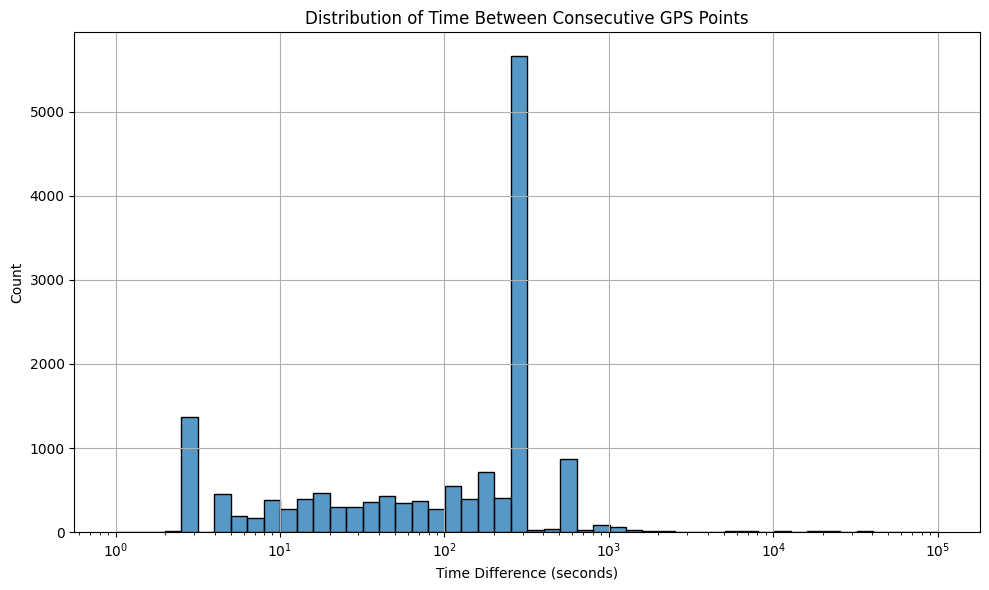

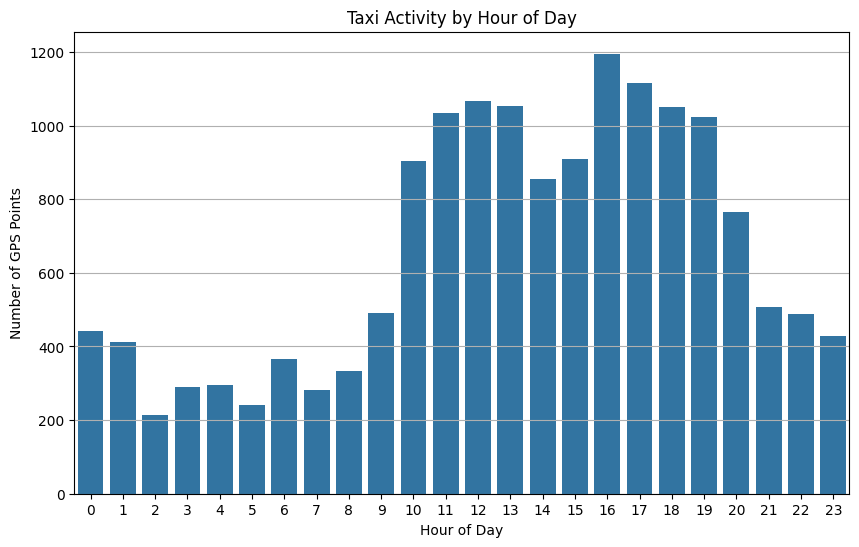


Taxis with longest stationary periods:
        datetime                                             time_diff  \
           count                 min                 max          mean   
taxi_id                                                                  
10004          8 2008-02-03 09:21:37 2008-02-08 11:12:17  62662.857143   
10005        625 2008-02-02 13:48:51 2008-02-08 17:39:11    852.916667   
100         1323 2008-02-02 18:44:59 2008-02-08 15:29:22    383.254917   
10          5617 2008-02-02 13:32:03 2008-02-08 17:38:00     94.935363   
10001        807 2008-02-02 13:34:36 2008-02-08 14:00:40    645.116625   

                   distance             
              max      mean        sum  
taxi_id                                 
10004    101543.0  0.136417   0.954918  
10005     78528.0  0.011300   7.051303  
100       75492.0  0.010793  14.268204  
10        49038.0  0.002136  11.996672  
10001     48856.0  0.012919  10.412784  


In [2]:
####################### 
#### Data Analysis ####

combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nCombined data shape: {combined_df.shape}")

# Check for duplicates
duplicate_count = combined_df.duplicated().sum()
print(f"\nNumber of duplicate records: {duplicate_count}")

# Calculate time differences and movement between consecutive points
combined_df = combined_df.sort_values(['taxi_id', 'datetime'])
combined_df['time_diff'] = combined_df.groupby('taxi_id')['datetime'].diff().dt.total_seconds()

# Calculate distance between consecutive points
combined_df['lon_diff'] = combined_df.groupby('taxi_id')['longitude'].diff()
combined_df['lat_diff'] = combined_df.groupby('taxi_id')['latitude'].diff()
combined_df['distance'] = np.sqrt(combined_df['lon_diff']**2 + combined_df['lat_diff']**2)

# Identify stationary periods (time difference > 5 min but minimal movement)
time_threshold = 300  # 5 minutes
distance_threshold = 0.0001  # Small threshold for coordinates

stationary_periods = combined_df[
    (combined_df['time_diff'] > time_threshold) & 
    (combined_df['distance'] < distance_threshold)
]

print(f"\nFound {len(stationary_periods)} potentially stationary periods (taxi stopped for >5 min)")

if not stationary_periods.empty:
    print("\nSample of stationary periods:")
    print(stationary_periods[['taxi_id', 'datetime', 'time_diff', 'distance']].head())

# Plot distribution of time differences
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['time_diff'].dropna(), bins=50, log_scale=True)
plt.title('Distribution of Time Between Consecutive GPS Points')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze taxi activity by hour
plt.figure(figsize=(10, 6))
combined_df['hour'] = combined_df['datetime'].dt.hour
hourly_counts = combined_df.groupby('hour').size()
sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title('Taxi Activity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of GPS Points')
plt.grid(True, axis='y')
plt.show()

# Identify taxis with unusual patterns
taxi_stats = combined_df.groupby('taxi_id').agg({
    'datetime': ['count', 'min', 'max'],
    'time_diff': ['mean', 'max'],
    'distance': ['mean', 'sum']
})

print("\nTaxis with longest stationary periods:")
print(taxi_stats.sort_values(('time_diff', 'max'), ascending=False).head(5))